# 1. Ejemplo de clasificación con KNN
#Identificación de Sargazo

Infirmación tomada del artículo ERISNet: deep neural network for
Sargassum detection along the coastline
of the Mexican Caribbean

Número de instancias: 4515

Atributos : 14

Output: Sargazo o No sargazo

#2. Importación de librerías y montando google drive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.6 K-vecinos cercanos'
dataset_path = os.path.join(path,'sargazo.csv')

# 3. Lectura y visualuzación del dataset

In [ ]:
train_df = pd.read_csv(dataset_path)
clases = train_df['label'].unique()
train_df.dropna(axis=0, inplace=True)
train_df.head(10)

,rhos_412,rhos_469,rhos_555,rhos_645,rhos_859,rhos_1240,rhos_2130,rhot_412,rhot_469,rhot_555,rhot_645,rhot_859,rhot_1240,rhot_2130,label
0,0.052152,0.052925,0.078956,0.059047,0.313018,0.221179,0.055593,0.145013,0.109765,0.098671,0.070267,0.314117,0.221700,0.055711,sargasso
1,0.071715,0.078672,0.105367,0.094236,0.312824,0.239947,0.055137,0.159696,0.131188,0.121568,0.102363,0.313924,0.240425,0.055256,sargasso
2,0.093493,0.103664,0.130337,0.125554,0.298491,0.258938,0.109737,0.176205,0.152149,0.143309,0.131019,0.299732,0.259376,0.109834,sargasso
3,0.116702,0.132209,0.161380,0.137303,0.256020,0.209399,0.107257,0.194006,0.176303,0.170476,0.141800,0.257693,0.209948,0.107355,sargasso
4,0.180689,0.212103,0.230556,0.184178,0.181868,0.180037,0.167550,0.241338,0.241300,0.229111,0.184354,0.184206,0.175584,0.141222,sargasso
5,0.198726,0.239960,0.244444,0.165483,0.162699,0.164481,0.152283,0.254202,0.263786,0.240970,0.167447,0.165396,0.160523,0.128382,sargasso
6,0.198726,0.239960,0.244444,0.165483,0.162699,0.164481,0.152283,0.254202,0.263786,0.240970,0.167447,0.165396,0.160523,0.128382,sargasso
7,0.145069,0.169582,0.213088,0.181584,0.183040,0.188655,0.136697,0.216015,0.208242,0.216042,0.182524,0.185580,0.189256,0.136784,sargasso
8,0.136558,0.161866,0.205121,0.173587,0.168291,0.154430,0.120288,0.209394,0.201620,0.208991,0.175153,0.171029,0.155122,0.120381,sargasso
9,0.147213,0.175907,0.223769,0.188709,0.172623,0.160728,0.126777,0.217729,0.213698,0.225498,0.189088,0.175304,0.161403,0.126868,sargasso


#4. Escalamiento

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

#5. Codificación de etiquetas

In [ ]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)


In [ ]:
train_df.head(10)

,rhos_412,rhos_469,rhos_555,rhos_645,rhos_859,rhos_1240,rhos_2130,rhot_412,rhot_469,rhot_555,rhot_645,rhot_859,rhot_1240,rhot_2130,label
0,0.052152,0.052925,0.078956,0.059047,0.313018,0.221179,0.055593,0.145013,0.109765,0.098671,0.070267,0.314117,0.221700,0.055711,1
1,0.071715,0.078672,0.105367,0.094236,0.312824,0.239947,0.055137,0.159696,0.131188,0.121568,0.102363,0.313924,0.240425,0.055256,1
2,0.093493,0.103664,0.130337,0.125554,0.298491,0.258938,0.109737,0.176205,0.152149,0.143309,0.131019,0.299732,0.259376,0.109834,1
3,0.116702,0.132209,0.161380,0.137303,0.256020,0.209399,0.107257,0.194006,0.176303,0.170476,0.141800,0.257693,0.209948,0.107355,1
4,0.180689,0.212103,0.230556,0.184178,0.181868,0.180037,0.167550,0.241338,0.241300,0.229111,0.184354,0.184206,0.175584,0.141222,1
5,0.198726,0.239960,0.244444,0.165483,0.162699,0.164481,0.152283,0.254202,0.263786,0.240970,0.167447,0.165396,0.160523,0.128382,1
6,0.198726,0.239960,0.244444,0.165483,0.162699,0.164481,0.152283,0.254202,0.263786,0.240970,0.167447,0.165396,0.160523,0.128382,1
7,0.145069,0.169582,0.213088,0.181584,0.183040,0.188655,0.136697,0.216015,0.208242,0.216042,0.182524,0.185580,0.189256,0.136784,1
8,0.136558,0.161866,0.205121,0.173587,0.168291,0.154430,0.120288,0.209394,0.201620,0.208991,0.175153,0.171029,0.155122,0.120381,1
9,0.147213,0.175907,0.223769,0.188709,0.172623,0.160728,0.126777,0.217729,0.213698,0.225498,0.189088,0.175304,0.161403,0.126868,1


In [ ]:
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

#6. Dividiendo el dataset en entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y)


print(f'Dimension de los datos de entrenamiento {X_train.shape}')
print(f'Dimension de los datos de prueba {X_test.shape}')

Dimension de los datos de entrenamiento (3612, 14)
Dimension de los datos de prueba (903, 14)


#7. Entrenando el modelo para obtener valor de k óptimo

(1.0, 15.0)

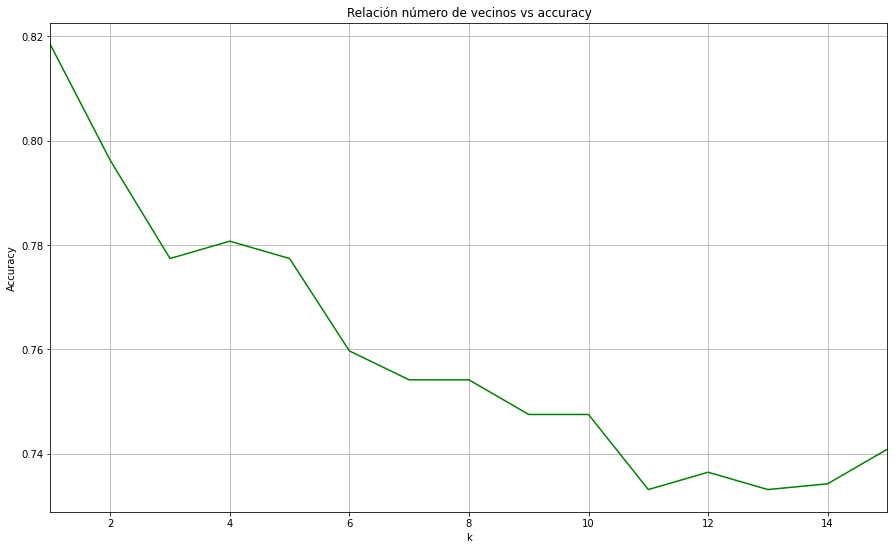

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
x_k = []
y_k = []

for i in range(15):
  classifier = KNeighborsClassifier(n_neighbors = i+1, metric = 'euclidean', p = 2)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  x_k.append(i+1)
  y_k.append(score)


plt.figure(figsize=(15, 9))
plt.plot(x_k,y_k,color = 'green')
plt.title('Relación número de vecinos vs accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xlim(np.min(x_k), np.max(x_k))

#8. Entrenando el modelo de KNN con k=2

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 2, metric = 'euclidean', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

#9. Prediciendo resultados

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
#Funciones para MC y métricas
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

Matriz de confusión

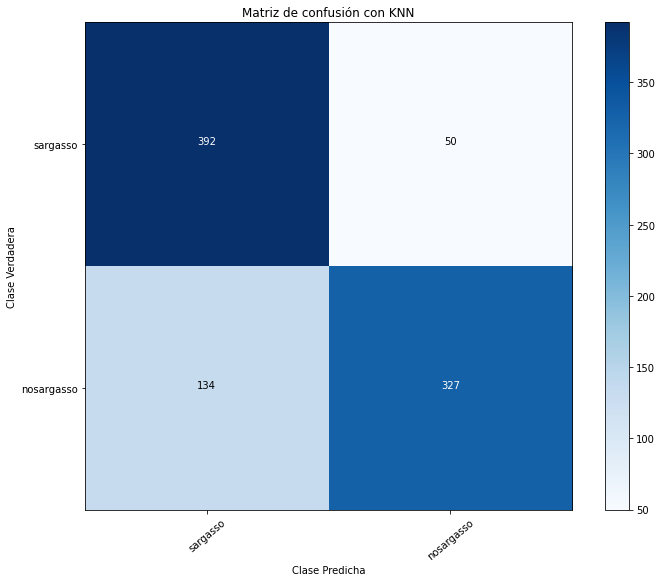

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
n_classes = 2
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_classes))
tit = 'Matriz de confusión con KNN'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

In [ ]:
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
print(pesos)

[0.48925803 0.51074197]


Métricas por clase 

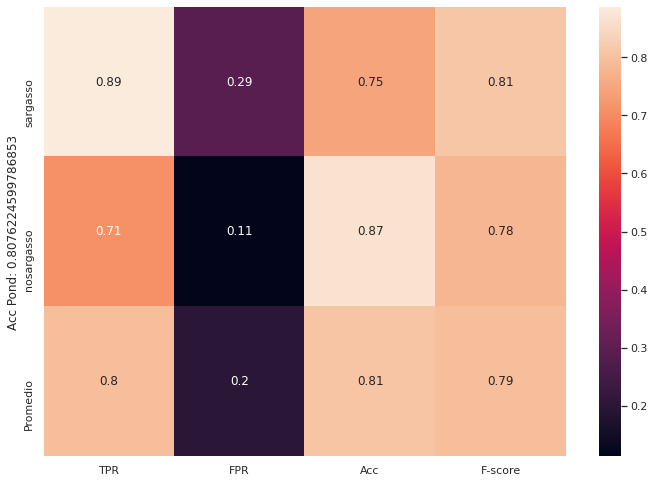

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_classes), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases.tolist()+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)